# Localization Tutorial


이 장에서는 Dead-reckoning 실습을 할 예정입니다

다음 장에서는 라이브러리를 import 해주세요

In [1]:
# %matplotlib inline
import tifffile
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
from IPython.display import HTML, Image
from matplotlib import animation

import scipy.io
from scipy import spatial
import numpy as np
import utm

## Map 데이터 불러오기
다음으로는 맵 이미지를 불러옵니다. .tif 파일로 맵이 저장되어 있고, 이를 불러옵니다.

{'KeyDirectoryVersion': 1,
 'KeyRevision': 1,
 'KeyRevisionMinor': 0,
 'GTModelTypeGeoKey': <ModelType.Geographic: 2>,
 'GTRasterTypeGeoKey': <RasterPixel.IsArea: 1>,
 'GeographicTypeGeoKey': <GCS.WGS_84: 4326>,
 'ModelPixelScale': [0.00010662080000000174, 2.3319733333333184e-05, 0.0],
 'ModelTiepoint': [0.0, 0.0, 0.0, 127.0400148, 37.5899662, 0.0]}

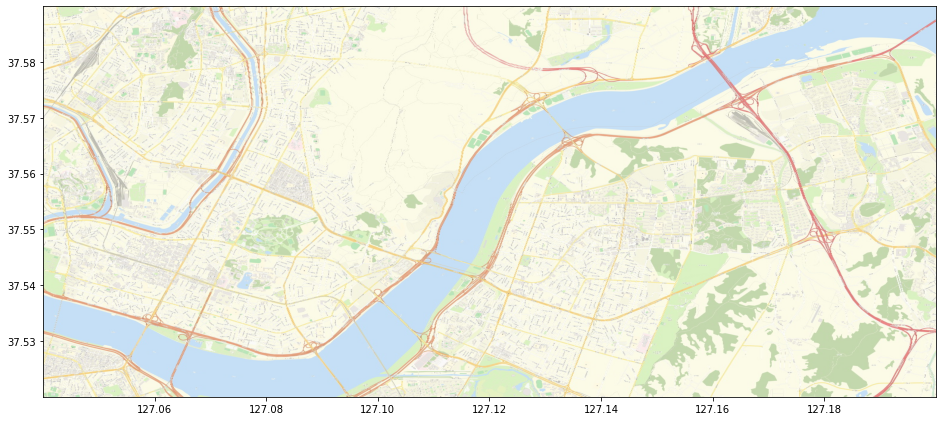

In [2]:
tif = tifffile.TiffFile('usgsImageryLayer_3000_1500.tif')
page = tif.pages[0]
lon_min = page.geotiff_tags.get('ModelTiepoint')[3]
lat_max = page.geotiff_tags.get('ModelTiepoint')[4]

ModelPixelScale_lon = page.geotiff_tags.get('ModelPixelScale')[0]
ModelPixelScale_lat = page.geotiff_tags.get('ModelPixelScale')[1]
lat_pixel = page.shape[0]
lon_pixel = page.shape[1]

lon_max = lon_min + ModelPixelScale_lon*lon_pixel
lat_min = lat_max - ModelPixelScale_lat*lat_pixel
fig = plt.figure(1, figsize=(16, 12))
ax = fig.add_subplot(111)
ax.imshow(page.asarray(),extent=[lon_min, lon_max, lat_min, lat_max])
page.geotiff_tags

OSM(Open Street Map) 데이터를 불러오는 코드입니다. 

mat 파일로 저장되어 있고, 이를 불러옵니다.

우리가 이용할 Semantic Map 데이터는 Waypoint latitude, longitude, osm_id로 되어 있습니다.

초록색 선은 osm 데이터에 있는 road segment waypoint들이고, 검정색 점은 road segment의 양끝단 Node 입니다.

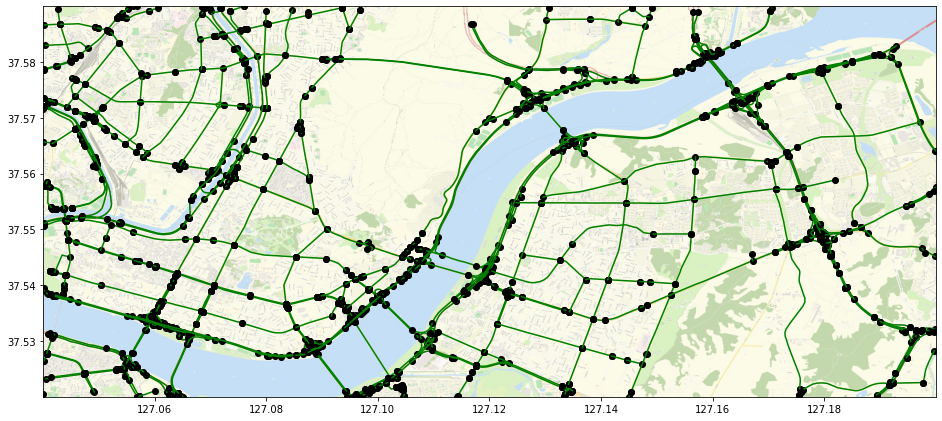

In [3]:
mat = scipy.io.loadmat('osm_nodes.mat')
osm_nodes = mat.get('osm_nodes')

prev_id = 0
longitudes = []
latitudes = []
node_lat_lons = []
node_ids = []
for node in osm_nodes:
    longitude = node['Lon'][0].reshape(-1)
    latitude = node['Lat'][0].reshape(-1)
    id = node['osm_id'][0].reshape(-1)
    node_lat_lons.append([latitude, longitude])
    node_ids.append(id)
    if prev_id != id:
        ax.plot(longitudes,latitudes,'g')
        if len(longitudes) > 1:
            ax.plot(longitudes[-1],latitudes[-1],'ko')
        ax.plot(longitude,latitude,'ko')
        longitudes = [longitude]
        latitudes = [latitude]
        prev_id = id
    else:
        longitudes.append(longitude)
        latitudes.append(latitude)
        
node_lat_lons = np.array(node_lat_lons).reshape(-1,2)
kd_tree = spatial.KDTree(node_lat_lons, leafsize=70)
fig

## Logging 데이터 불러오기
로깅 데이터의 각각 이름들은 다음과 같습니다.

'gps_heading', 'gps_lat', 'gps_lon', 'gps_speed', 'logging_time', 'wheel_speed', 'yaw_rate'

파란색 점들은 GPS가 로깅된 위치들이고, 빨간색 표시는 시작점입니다.

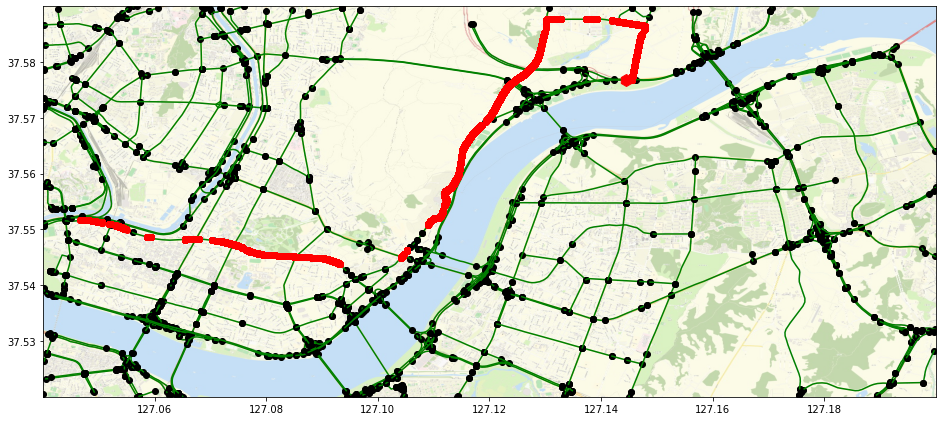

In [4]:
logging_mat = scipy.io.loadmat('logging_data.mat')
x,y,let_num,let_char=utm.from_latlon(latitude,longitude)

## 로깅된 시간은 모두 Sychronized 되었다고 가정하였음
logging_time = logging_mat.get('logging_time')   #(s)
wheel_speed_log = logging_mat.get('wheel_speed') #(km/h)
yaw_rate_log = logging_mat.get('yaw_rate')       #(deg/s)

gps_lat_log = logging_mat.get('gps_lat')         #(deg)
gps_lon_log = logging_mat.get('gps_lon')         #(deg)
gps_speed_log = logging_mat.get('gps_speed')     #(km/h)
gps_heading_log = logging_mat.get('gps_heading') #(deg)

ax.plot(gps_lon_log[0,1],gps_lat_log[0,1],'rh', markersize=12)
ax.plot(gps_lon_log[:,1],gps_lat_log[:,1],'ro')
fig

## TODO (Dead Reckoning)
여러분은 이제 이 코드에서 UKF 모델을 개발하시면 됩니다. Prediction을 진행 할 때에는 CTRV(constant turn rate velocity)모델을 활용합니다.

그런다음 Correction 단계에서는 GPS 데이터를 이용합니다. 이때, gps_received 되었을 때 correction이 되는것으로 작성하시면 됩니다.
또한 gps 각각은 state와 linear한 관계로 있기 때문에, Linear kalman filter의 Correction으로 써도 무방합니다

In [5]:
def UKF(x_prev, P_prev, gps_x, gps_y, gps_vel, gps_heading, veh_yawrate, wheel_speed, gps_received):
    '''
    TODO: 여기서 UKF 알고리즘을 개발하세요!
    (0) Input 신호
    gps_x: gps x 위치(m) 
    gps_y: gps y 위치(m)
    gps_vel: gps 속도(km/h)
    gps_heading: gps heading(deg)
    veh_yawrate: 차량의 yaw rate(deg/s)
    wheel_speed: 차량의 front left 휠속(km/h)
    gps_received: gps 수신 여부
    
    
    (1) Prediction
    CTRV model을 이용하여 prediction 진행
    
    (2) Correction
    GPS 정보를 이용하여 Correction 진행
    단, gps_x, gps_y 정보만 이용하는것을 권장함
    '''
    
    
    x = None
    P = None
    return x, P

## Main Execution Code
이제 이 코드에서 실행시킵니다. GPS는 일부 데이터가 불량하여 일부 구간에서 잡히지 않는 시나리오로 되어있습니다.

In [7]:
gps_time_idx = 0
gps_lat_prev = 0
gps_lon_prev = 0
initialized = False
x_stack = []
for i in range(len(logging_time)):
    # time에 따른 데이터 input 가져오기
    time = logging_time[i]
    wheel_speed = wheel_speed_log[i][1] / 3.6
    yaw_rate = yaw_rate_log[i][1] /180 * 3.141592
    
    # GPS는 일부 데이터가 신호 불량하여 잡히지 않음
    gps_time = gps_lat_log[i - gps_time_idx][0]
    if time < gps_time:
        gps_time_idx += 1
        gps_received = False
    else:
        gps_lat = gps_lat_log[i - gps_time_idx][1]
        gps_lon = gps_lon_log[i - gps_time_idx][1]
        gps_speed = gps_speed_log[i - gps_time_idx][1] / 3.6
        gps_heading = gps_heading_log[i - gps_time_idx][1] / 180 *3.141592
        gps_received = True
    if (gps_lat_prev is gps_lat and gps_lon_prev is gps_lon):
        gps_received = False
    
    # WGS84 to UTMzone 변환 (lat,lon to x,y)
    gps_x_abs, gps_y_abs, let_num, let_char=utm.from_latlon(gps_lat,gps_lon)
    if i ==0:
        gps_x0 = gps_x_abs
        gps_y0 = gps_y_abs
        gps_x = 0
        gps_y = 0
    else:
        gps_x = gps_x_abs - gps_x0
        gps_y = gps_y_abs - gps_y0
        
    if not initialized:
        if gps_speed == 0:
            continue
        x_prev = np.array([[gps_x], [gps_y], [gps_speed], [gps_heading], [yaw_rate]])

        # % initalize sigma
        sig_px = 10
        sig_py = 10
        sig_v = 5
        sig_yaw = np.pi/10
        sig_yawrate = np.pi/20
        P_prev = np.diag([sig_px, sig_py, sig_v, sig_yaw, sig_yawrate])
        initialized = True
    
    # GPS, yawrate, wss를 활용한 Deadreckoning 알고리즘 실행
    x, P = UKF(x_prev, P_prev, gps_x, gps_y, gps_speed, gps_heading, yaw_rate, wheel_speed, gps_received)
    
    # UTMzone to WGS84 역변환 (참고)
    # est_x = x[0]
    # est_y = x[1]
    # lat, lon = utm.to_latlon(est_x + gps_x0, est_y + gps_y0, let_num, let_char)
    
    x_prev = x
    P_prev = P
    gps_lat_prev = gps_lat
    gps_lon_prev = gps_lon
    # x_stack.append([lon, lat, x[2], x[3], x[4]])
# x_stack = np.array(x_stack)
# ax.plot(x_stack[:,0],x_stack[:,1],'bo')
# fig

결과는 다음과 같이 유사하게 나오면 됩니다

<img src="결과.png" width="1000">

<img src="결과2.png" width="1000">

## Bonus 문제 (Map Matching)

이 코드에서는 내 위치가 도로의 몇번째 아이디에 해당하는지 찾는 알고리즘입니다.

KD tree를 통해서 내 위치와 가장 가까운 10개의 Node를 뽑고, 해당하는 road segment id를 찾습니다.

그 중에서 자신의 위치에 해당하는 id를 찾는것이 목적입니다.

이 코드를 실행하면 GPS의 위치에 따른 인접한 road segment id를 찾습니다.

In [ ]:
'''
TODO
뽑은 Segment id 중 가장 적합한 segment id 찾기

'''
fig.set_size_inches(4,4)
def drawframe(n):
    line, = ax.plot([], [], 'k')     # ax.plot returns a list of 2D line objects
    marker, = ax.plot([], [], 'ro')
    gps_lat = gps_lat_log[n][1]
    gps_lon = gps_lon_log[n][1]
    dists, indices = kd_tree.query([gps_lat, gps_lon], k=10)
    seg_ids = []
    for idx in indices:
        seg_id = node_ids[idx]
        if seg_ids.count(seg_id) < 1:
            seg_ids.append(seg_id)
    for seg_id in seg_ids:
        same_id = node_ids == seg_id
        seg_lat_lon = node_lat_lons[same_id.reshape(-1),:]
        line.set_data(seg_lat_lon[:,1],seg_lat_lon[:,0])
        marker.set_data(gps_lon, gps_lat)
    ax.set_xlim(gps_lon-0.005, gps_lon+0.005)
    ax.set_ylim(gps_lat-0.005, gps_lat+0.005)
    return(line, marker)



In [ ]:
anim = animation.FuncAnimation(fig, drawframe, frames=len(gps_lat_log), interval=1, blit=False)
anim.save('dynamic_images.gif')

In [ ]:
display(Image(data=open('dynamic_images.gif','rb').read(), format='png'))